In [1]:
import sys
print('iPython Kernel -->', sys.argv)
print('Environment -->', sys.prefix)

iPython Kernel --> ['C:\\anaconda3\\envs\\ling\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Babak Ravandi\\AppData\\Roaming\\jupyter\\runtime\\kernel-59fc5995-97cb-4d77-ae5d-e09523b2b26b.json']
Environment --> C:\anaconda3\envs\ling


In [2]:
import pandas as pd
import numpy as np
import json
from collections import OrderedDict 

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import random

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns

import networkx as nx
import GraphHierarchy as gh

from tqdm import tqdm

from scipy import stats

import gspread

'''
This layout algorithm requires installin graphviz
https://pygraphviz.github.io/documentation/stable/install.html
'''
from networkx.drawing.nx_agraph import graphviz_layout

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_colwidth', 0)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

%matplotlib inline

In [3]:
import os
from pandas import ExcelWriter


def save_xls(dfs_dict, xls_path, open=False):
    if type(dfs_dict) is not dict:
        dfs_dict = {'sheet1': dfs_dict}
    
    with ExcelWriter(xls_path) as writer:
        for df_name, df in dfs_dict.items():
            df.to_excel(writer, df_name)
        writer.save()

    if open is True:
        os.system('start EXCEL.EXE "{}"'.format(os.path.abspath(xls_path)))
    pass

In [4]:
# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [5]:
def lenght_all_pairs_shortest_path(G_nx):
    q = nx.all_pairs_shortest_path(G_nx)
    
    p_all = []

    for p in q:
        p_all.append(p)

    p_lenght = []
    path_df = []
    
    for p_2 in [p[1].values() for p in p_all]:
        for p3 in p_2:
            p_lenght.append(len(p3))
            
            path_df.append({'l': len(p3), 'p': p3})
#         p_lenght += [len(p3) for p3 in p_2]

        pass
    
    path_df = pd.DataFrame(path_df)
    path_df['p'] = path_df['p'].astype('str')
    
    return path_df

# Load Networks

In [6]:
centuries = {
    '11': 11.0, '12': 12.0, '13': 13.0, '14E': 14.1, '14L': 14.2, '15': 15.0, '16': 16.0, '17': 17.0
}

## Check Mistake Duplicate Edges & Add Frequency

THe only exception of having multiple interactions between a source and target is in 17th century as below. ALl other centuries must have only a single interaction (type of edge) between two nodes.

Source:'PR ze'	 |	Target: 'IV werden'   |   Interactions: {PP, VP}

In [7]:
gc = gspread.service_account(filename='google_service_credentials.json')

In [8]:
google_sheet_ID = '1CWbPlXrKa41DL02mO6pny8BC4Hd7xwbIhA3-ZthyjWc'

german_dataset_gsheet = gc.open_by_key(google_sheet_ID)

german_dataset_gsheet.worksheets()

[<Worksheet '11' id:2063048793>,
 <Worksheet '12' id:936686375>,
 <Worksheet '13' id:698480864>,
 <Worksheet '14E' id:1758104757>,
 <Worksheet '14L' id:1538902914>,
 <Worksheet '15' id:2099895106>,
 <Worksheet '16' id:121866148>,
 <Worksheet '17' id:1360439213>,
 <Worksheet 'Descriptions' id:646251015>,
 <Worksheet 'Shortkeys!' id:1846877574>]

In [9]:
cent_interaction_validate = {}
cent_raw_df = {}
cent_df_dict = {}
'''This is to have the option of more complex network'''
enforce_single_function = True

for cent in centuries.keys():

    print('------------ Cent:', cent)
    
    cent_df = pd.DataFrame(german_dataset_gsheet.worksheet(cent).get_all_records())

    cent_df.loc[:, ['Source', 'Target', 'Interaction']] = (
        cent_df.loc[:, ['Source', 'Target', 'Interaction']].apply(lambda x: x.str.strip(), axis=1)
    ) 
    
    cent_df['Source Funcs All'] = cent_df['Source'].apply(lambda x: x.split(' ')[0])
    cent_df['Source Func Single'] = cent_df['Source Funcs All'].apply(lambda x: x.split('/')[0])

    cent_df['Target Funcs All'] = cent_df['Target'].apply(lambda x: x.split(' ')[0])
    cent_df['Target Func Single'] = cent_df['Target Funcs All'].apply(lambda x: x.split('/')[0])

    cent_df['Source Single Func'] = cent_df['Source Func Single'] + ' ' + cent_df['Source'].apply(lambda x: ' '.join(x.split(' ')[1:]))
    cent_df['Target Single Func'] = cent_df['Target Func Single'] + ' ' + cent_df['Target'].apply(lambda x: ' '.join(x.split(' ')[1:]))

    cent_df['Source All Funcs'] = cent_df['Source']
    cent_df['Target All Funcs'] = cent_df['Target']

    if enforce_single_function is True:
        cent_df['Source'] = cent_df['Source Single Func']
        cent_df['Target'] = cent_df['Target Single Func']

    cent_raw_df[cent] = cent_df.copy()
    
    """"""
    G=nx.from_pandas_edgelist(
        cent_df, source='Source', target='Target', 
        edge_attr=True, create_using=nx.DiGraph()
    )
    
    # nx.draw(G, with_labels=True)
    # print(type(G))
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    print('num edges in dataset:', len(cent_df), ' num network edges:', G.number_of_edges())
    """"""

    cent_df['frequency'] = cent_df['Interaction']

    cent_df = (
        cent_df.groupby(['Source', 'Target'])
        .agg({
            'Interaction': lambda x: set([v.upper() for v in x]),
            'frequency': np.size,
         })
        .reset_index()
    )

    cent_df['Interaction count'] = cent_df['Interaction'].apply(len)

    # print(path_net)
    cent_df = cent_df.sort_values(by=['Interaction count', 'frequency'], ascending=False)

    cent_df_dict[cent] = cent_df
    
    cent_interaction_validate[cent] = cent_df[cent_df['Interaction count'] > 1]  
    
    print(
        'Interaction count > 1 -->', len(cent_interaction_validate[cent])
    )
    
    del cent_df
#     break
    pass
# cent_df_dict.keys()
# cent_df = cent_raw_df[cent]
print('IMP enforce_single_function:', enforce_single_function)

------------ Cent: 11
num edges in dataset: 971  num network edges: 726
Interaction count > 1 --> 0
------------ Cent: 12
num edges in dataset: 1194  num network edges: 805
Interaction count > 1 --> 0
------------ Cent: 13
num edges in dataset: 2504  num network edges: 1332
Interaction count > 1 --> 1
------------ Cent: 14E
num edges in dataset: 2327  num network edges: 1322
Interaction count > 1 --> 0
------------ Cent: 14L
num edges in dataset: 2494  num network edges: 1587
Interaction count > 1 --> 0
------------ Cent: 15
num edges in dataset: 2227  num network edges: 1424
Interaction count > 1 --> 1
------------ Cent: 16
num edges in dataset: 3349  num network edges: 2454
Interaction count > 1 --> 0
------------ Cent: 17
num edges in dataset: 3940  num network edges: 3085
Interaction count > 1 --> 1


In [10]:
cent = '11'
cent_raw_df[cent]
cent_df_dict[cent]

,Source,Target,Interaction,frequency,Interaction count
72,AX werden,PP er,{VP},43,1
715,V werden,PP er,{VP},12,1
18,AX sin,PcPs werden,{VP},11,1
68,AX werden,PK ne,{VP},9,1
71,AX werden,PP du,{VP},9,1
...,...,...,...,...,...
717,V werden,PP ieman,{VP},1,1
719,V werden,PR durch,{VP},1,1
720,V werden,PR in,{VP},1,1
724,V wesen,AJ schoene,{VP},1,1


In [11]:
print('WE MUST HAVE Only two nodes with multiple edges!')
cent_interaction_validate['17']

WE MUST HAVE Only two nodes with multiple edges!


,Source,Target,Interaction,frequency,Interaction count
374,AX werden,PP er,"{VP, PP}",92,2


## Tree Specs and Validation

In [30]:
sentence_cent_df = []
G_list = {}
G_not_tree_list = {}
root_codes = [1, -1, -2] # tree, '', cycle (why cycle valentina?)

type_source_target = 0
col_source = ['Source Single Func', 'Source All Funcs'][type_source_target]
col_target = ['Target Single Func', 'Target All Funcs'][type_source_target]

for cent in centuries.keys():
#     if cent != '16':
#         continue
        
    print('------------------Cent: {} | {} -> {}------------------'.format(cent, col_source, col_target))
    
    sentence_started = False
    G = None
    row_num = 0
    root_row_num_current = None

    tree_root = None
    is_root_code = None

    G_list[cent] = []
    G_not_tree_list[cent] = []

    for source, target, is_root in cent_raw_df[cent][[col_source, col_target, 'Root']].to_numpy():
        if (sentence_started is True and is_root in root_codes) or (row_num == len(cent_raw_df[cent]) - 1):
            
            # in case no root is marked
            if G is None:
                row_num += 1
                continue
            
            sentence_started = False
           
            diameter_from_all_directed_paths = None
            diemter_from_undirected_graph = None
            diameter_from_positions = None
            
            
            is_tree = nx.is_tree(G)
            
            if(is_tree):    
                path_df = lenght_all_pairs_shortest_path(G)
                diameter_from_all_directed_paths = path_df['l'].max()
                
                diemter_from_undirected_graph = nx.diameter(G.to_undirected())
                
                pos = hierarchy_pos(G, root=tree_root)
                diameter_from_positions =  len(set([v[1] for v in pos.values()]))
                
                if is_root_code != 1:
                    G_not_tree_list[cent].append((root_row_num_current, is_root_code + -0.1, G))
            else:
                G_not_tree_list[cent].append((root_row_num_current, is_root_code, G))
    #             print('not tree')
                pass
            pass
    
            G_list[cent].append({
                'cent': cent,
                'root':tree_root, 
                'root code': is_root_code,
                'is_tree_nx': is_tree,
                'G': G,
                'diameter from all directed paths': diameter_from_all_directed_paths,
                'diameter from undirected graph': diemter_from_undirected_graph,
                'tree height from positions': diameter_from_positions
            })

        #if is_root == 1:
        if is_root in root_codes:
            is_root_code = is_root
            sentence_started = True
            root_row_num_current = row_num
            tree_root = source
            G = nx.DiGraph()
            pass
        
        # in case no root is marked
        if G is not None:
            G.add_edge(source, target)

        row_num += 1
        pass

    del is_root, is_root_code
    print('Num Sentences:', len(G_list[cent]), 'Num NOT trees:', len(G_not_tree_list[cent]))
    
    cent_tree_specs_df = pd.DataFrame(G_list[cent])
    
    if 'is_root' in cent_tree_specs_df:
        print('root code freq:\n', cent_tree_specs_df['is_root'].fillna('NA').value_counts())
    
    sentence_cent_df.append(cent_tree_specs_df)
    pass

sentence_cent_df = pd.concat(sentence_cent_df).reset_index(drop=True)

------------------Cent: 11 | Source Single Func -> Target Single Func------------------
Num Sentences: 238 Num NOT trees: 19
------------------Cent: 12 | Source Single Func -> Target Single Func------------------
Num Sentences: 302 Num NOT trees: 14
------------------Cent: 13 | Source Single Func -> Target Single Func------------------
Num Sentences: 687 Num NOT trees: 22
------------------Cent: 14E | Source Single Func -> Target Single Func------------------
Num Sentences: 604 Num NOT trees: 52
------------------Cent: 14L | Source Single Func -> Target Single Func------------------
Num Sentences: 568 Num NOT trees: 56
------------------Cent: 15 | Source Single Func -> Target Single Func------------------
Num Sentences: 539 Num NOT trees: 38
------------------Cent: 16 | Source Single Func -> Target Single Func------------------
Num Sentences: 651 Num NOT trees: 89
------------------Cent: 17 | Source Single Func -> Target Single Func------------------
Num Sentences: 724 Num NOT trees: 1

In [31]:
print(len(sentence_cent_df))
sentence_cent_df.head()

4313


,cent,root,root code,is_tree_nx,G,diameter from all directed paths,diameter from undirected graph,tree height from positions
0,11,AX werden,1,True,"(AX werden, PcPs pflanzen, DM der, PR zu, N jerusalem)",4.0,4.0,4.0
1,11,AX werden,1,True,"(AX werden, PcPs beswichen, PP ich, PK niht, PR mit, N doctrina, AJ perversus)",5.0,5.0,5.0
2,11,V werden,1,True,"(V werden, AD so, N auditor, AJ din)",3.0,3.0,3.0
3,11,AX sin,1,True,"(AX sin, PcPs werden, PP ich, AJ edel, PR von, N cyprus)",4.0,3.0,4.0
4,11,AX werden,1,True,"(AX werden, PcPs geantvristen)",2.0,1.0,2.0


In [32]:
sentence_cent_df.groupby('cent').agg(
    max_diameter_directed_paths=('diameter from all directed paths', np.max),
    max_diameter_undirected_graph=('diameter from undirected graph', np.max),
    max_tree_height_from_positions=('tree height from positions', np.max)
)

,max_diameter_directed_paths,max_diameter_undirected_graph,max_tree_height_from_positions
cent,,,
11,7.0,7.0,7.0
12,6.0,7.0,6.0
13,6.0,7.0,6.0
14E,7.0,7.0,7.0
14L,6.0,7.0,6.0
15,6.0,7.0,6.0
16,7.0,9.0,7.0
17,8.0,10.0,8.0


### Export Not Trees

In [15]:
path_export_trees_dir = "D:/GoogleDrive/Research/Linguistic project/German/data/legacy/"
cent = '11'
print('Number of NOT tree items for cent', cent, ':')
pd.DataFrame(G_not_tree_list[cent], columns=['row number', 'root code', 'tree nx'])['root code'].value_counts()
# pd.DataFrame(G_list[cent])['root code'].value_counts()

Number of NOT tree items for cent 11 :


-2.0    5
-2.1    1
Name: root code, dtype: int64

In [16]:
'''
Export Not trees
'''

G_not_tree_list[cent] = sorted(G_not_tree_list[cent], key=lambda x: x[1], reverse=True)

limit_number_nets = 30
not_tree_df = []
num_not_tree = len(G_not_tree_list)
figs = []
ax_index = 0

for i, not_tree in tqdm(enumerate(G_not_tree_list[cent])):
    if i % limit_number_nets == 0:
        plt.close()
        
        fig, axs = plt.subplots(limit_number_nets, figsize=(10, limit_number_nets * 4), dpi=200)
        ax_index = 0
        
        figs.append(fig)
        pass

    not_tree_df.append({'row_num': row_num + 2, 'cent': cent})
    
    row_num, is_root_code, G = not_tree   

    pos=graphviz_layout(G, prog=['dot', 'twopi', 'sfdp', 'circo'][0])

    nx.draw(G, pos=pos, with_labels = True, ax=axs[ax_index])
    axs[ax_index].set_title(
        '--------------------------------------Row Number: {} | code: {} ({} from {})--------------------------------------'.format(
        row_num + 2,
        is_root_code,
        i + 1,
        num_not_tree
    ))
    
    ax_index += 1
    pass

plt.close()

not_tree_df = pd.DataFrame(not_tree_df)
not_tree_df.to_excel(path_export_trees_dir + 'not_tree/cent_{}.xlsx'.format(cent))

for i, fig in enumerate(figs):
    path_fig = path_export_trees_dir + 'not_tree/cent_{}_part_{}.png'.format(cent, i)
    fig.savefig(path_fig, bbox_inches='tight')
    print('Saved fig at: ', path_fig)
    del fig
    pass

del figs
    
print('Cent:', cent)
# plt.tight_layout()

6it [00:01,  4.75it/s]


Saved fig at:  D:/GoogleDrive/Research/Linguistic project/German/data/legacy/not_tree/cent_11_part_0.png
Cent: 11


Cent: 11
Tree height: 4


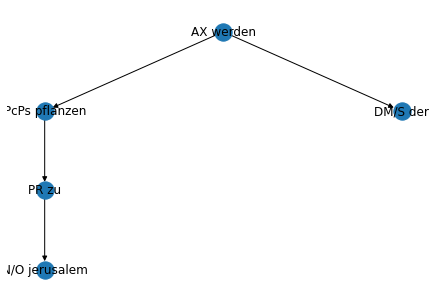

In [17]:
'''
Visualize a Tree
'''
# https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx
# from networkx.drawing.nx_pydot import graphviz_layout
# pos = graphviz_layout(giant, prog="circo")

# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
index_tree = [0, 515, 400][0]

tree_root = G_list[cent][index_tree]['root']
G = G_list[cent][index_tree]['G']

pos = hierarchy_pos(G, root=tree_root)

nx.draw(G, pos=pos, with_labels = True)

# nx.draw(giant, pos=nx.spring_layout(giant), with_labels = True)
print('Cent:', cent)
print('Tree height:', len(set([v[1] for v in pos.values()])))

Cent: 11
Tree height: 3 root code: -2


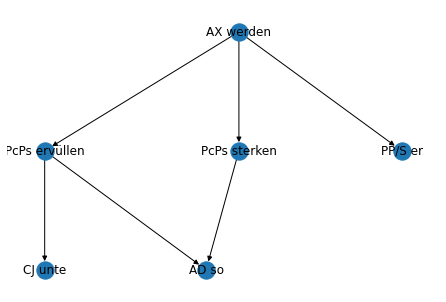

In [18]:
'''
Visualize a not tree sentence
'''
# https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx
# from networkx.drawing.nx_pydot import graphviz_layout
# pos = graphviz_layout(giant, prog="circo")

# https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
index_tree = [0, 515, 400][0]

row_number, root_code, G = G_not_tree_list[cent][index_tree]

pos=graphviz_layout(G, prog=['dot', 'twopi', 'sfdp', 'circo'][0])

nx.draw(G, pos=pos, with_labels = True)

# nx.draw(giant, pos=nx.spring_layout(giant), with_labels = True)
print('Cent:', cent)
print('Tree height:', len(set([v[1] for v in pos.values()])), 'root code:', root_code)

## Create Weighted Networks with Freq

In [20]:
cent_nets = OrderedDict()
syntactic_nets = []

for cent, cent_df in cent_df_dict.items():
    print('------- cent:', cent)
    
#     cent_df = pd.read_excel( path_dataset_dir + path_net).drop(columns='Unnamed: 0')
    
    cent_df['Source'] = cent_df['Source'].str.lower().apply(lambda x: x.split(' ')[0].upper() + ' ' + ' '.join(x.split(' ')[1:]))
    cent_df['Target'] = cent_df['Target'].str.lower().apply(lambda x: x.split(' ')[0].upper() + ' ' + ' '.join(x.split(' ')[1:]))
    
    cent_df.loc[:, 'Source':'Target'] = cent_df.loc[:, 'Source':'Target'].apply(
        lambda x: x.str.strip())
    
#     print(cent_df.columns)
    G = nx.from_pandas_edgelist(
        cent_df, 
        source='Source', 
        target='Target', 
        edge_attr=True,
#         edge_attr=['Interaction', 'frequency', 'Interaction count'], 
#         Created a directed graph
        create_using=nx.DiGraph()
    )
    
    cent_df['cent'] = cent
    syntactic_nets.append(cent_df)
    
    print('n:', G.number_of_nodes(), 'e:', G.number_of_edges())
    
    cent_nets[cent] = G
    pass

syntactic_nets = pd.concat(syntactic_nets).reset_index(drop=True)
syntactic_nets

------- cent: 11
n: 411 e: 724
------- cent: 12
n: 436 e: 805
------- cent: 13
n: 700 e: 1327
------- cent: 14E
n: 688 e: 1322
------- cent: 14L
n: 755 e: 1587
------- cent: 15
n: 735 e: 1424
------- cent: 16
n: 1191 e: 2454
------- cent: 17
n: 1563 e: 3085


,Source,Target,Interaction,frequency,Interaction count,cent
0,AX werden,PP er,{VP},43,1,11
1,V werden,PP er,{VP},12,1,11
2,AX sin,PCPS werden,{VP},11,1,11
3,AX werden,PK ne,{VP},9,1,11
4,AX werden,PP du,{VP},9,1,11
...,...,...,...,...,...,...
12730,V werden,PR allzu,{VP},1,1,17
12731,V werden,PR bei,{VP},1,1,17
12732,V werden,PR hinfür,{VP},1,1,17
12733,V werden,PR von,{VP},1,1,17


In [21]:
if False:
    path_syntactic_nets = path_dataset_dir + 'syntactic_nets_german.xlsx'
    print(path_syntactic_nets)
    syntactic_nets.to_excel(path_syntactic_nets)
    pass

In [22]:
nodes_all_cent = set(syntactic_nets['Source']).union(set(syntactic_nets['Target']))

[n for n in nodes_all_cent if 'werden' in n]

['AX werden', 'IV werden', 'V werden', 'PCPS werden']

### Validation | TODO FIX!!!

In [ ]:
# syntactic_nets.to_csv('german_ling_netwrok.csv')

In [23]:
syntactic_nets['Interaction str'] = syntactic_nets['Interaction'].astype(str)

syntactic_nets[syntactic_nets['Interaction str'] == "{''}"]

,Source,Target,Interaction,frequency,Interaction count,cent,Interaction str


In [24]:
'''
TODO FIX!
The ones with count = 1 seems to have an issue
'''

cent_interaction_count = syntactic_nets.groupby(['cent', 'Interaction str']).agg(count = ('Interaction', np.size))
if False:
    cent_interaction_count.to_excel('cent_interaction_count.xlsx')
    pass

cent_interaction_count

count
cent Interaction str       
11   {'NP'}           165  
     {'PP'}           81   
     {'VP'}           480  
12   {'NP'}           198  
     {'PP'}           79   
     {'VP'}           528  
13   {'NP'}           320  
     {'PP'}           178  
     {'VP', 'NP'}     1    
     {'VP'}           833  
14E  {'NP'}           333  
     {'PP'}           120  
     {'VP'}           869  
14L  {'NP'}           453  
     {'PP'}           169  
     {'VP'}           965  
15   {'FIXME'}        1    
     {'NP'}           369  
     {'PP', 'NP'}     1    
     {'PP'}           139  
     {'VP'}           914  
16   {'NP'}           666  
     {'PP'}           314  
     {'VP'}           1474 
17   {'FIXME'}        1    
     {'NP'}           890  
     {'PP'}           420  
     {'VP', 'PP'}     1    
     {'VP'}           1773

In [25]:
G.get_edge_data('AX werden','PP er')
# cent_df
# pd.read_excel( path_dataset_dir + path_net)
# path_dataset_dir + path_net

{'Interaction': {'PP', 'VP'},
 'frequency': 92,
 'Interaction count': 2,
 'cent': '17'}

# Analyze Diameter

In [26]:
diameter_cent_df = []

for cent, cent_G in tqdm(cent_nets.items()):
    path_df = lenght_all_pairs_shortest_path(cent_nets[cent])

    diameter_cent_df.append({
        'cent': cent,
        'avg pairwise shortest path': path_df['l'].mean(),
        'sentence height avg': sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'].mean(),
                
        'diameter (max pairwise shortest path)': path_df['l'].max(),
        'sentence height max': sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'].max(),
        
        'avg pairwise shortest path std': path_df['l'].std(),
        'sentence height std': sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'].std()
    })
    pass

diameter_cent_df = pd.DataFrame(diameter_cent_df)
diameter_cent_df

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.15it/s]


,cent,avg pairwise shortest path,sentence height avg,diameter (max pairwise shortest path),sentence height max,avg pairwise shortest path std,sentence height std
0,11,3.081967,3.429185,7,7.0,1.129234,1.176423
1,12,3.108770,3.439189,6,6.0,1.109658,1.093750
2,13,4.281210,3.223201,10,6.0,1.747316,1.129858
3,14E,3.119580,3.158974,6,7.0,0.998961,1.003603
4,14L,3.460135,3.389925,8,6.0,1.111358,1.063854
5,15,3.492065,3.308285,9,6.0,1.229940,1.038519
6,16,5.086368,3.818910,17,7.0,2.460398,1.142030
7,17,6.562516,3.985229,16,8.0,2.253155,1.230680


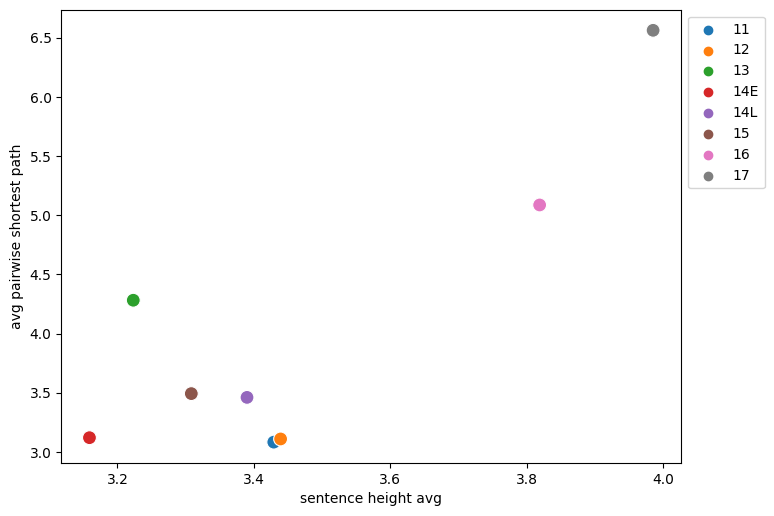

In [33]:
plt.figure(figsize=(8, 6), dpi=100)
ax = sns.scatterplot(data=diameter_cent_df, x="sentence height avg", y="avg pairwise shortest path", hue='cent',
               s=100, legend='full')
ax.legend(bbox_to_anchor=(1, 1))

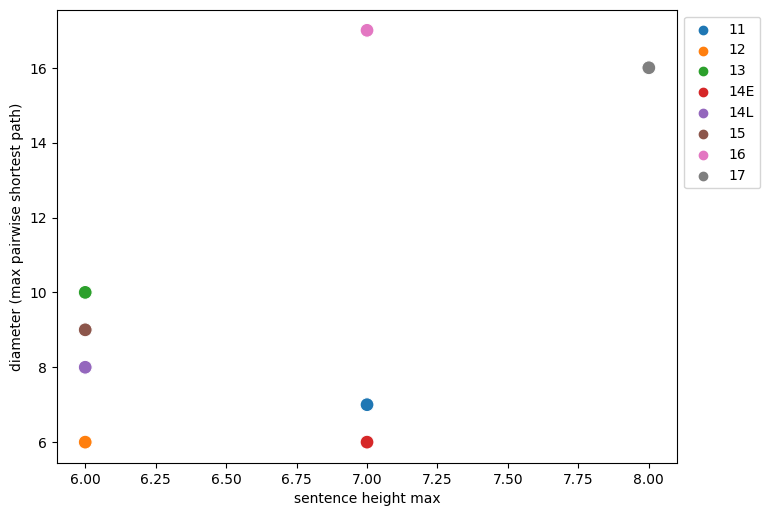

In [34]:
plt.figure(figsize=(8, 6), dpi=100)
ax = sns.scatterplot(data=diameter_cent_df, x="sentence height max", y="diameter (max pairwise shortest path)", hue='cent',
               s=100, legend='full')
ax.legend(bbox_to_anchor=(1, 1))

cent_diameter: 16 from 275587 all-pairs-paths


<AxesSubplot:xlabel='l', ylabel='Count'>

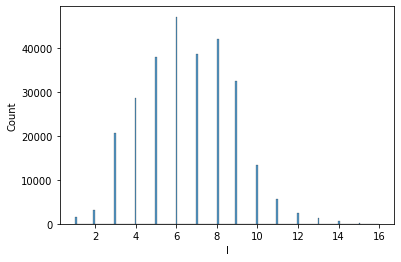

In [62]:
cent = '17'
path_df = lenght_all_pairs_shortest_path(cent_nets[cent])
cent_max_diameter = path_df['l'].max()
print('cent_diameter:', cent_diameter, 'from', len(path_df), 'all-pairs-paths')
sns.histplot(path_df['l'])

max tree diameter: 8.0


<AxesSubplot:xlabel='diameter from all directed paths', ylabel='Count'>

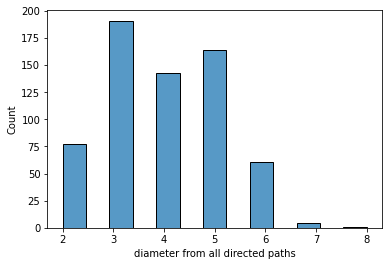

In [60]:
print('max tree diameter:', sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'].max())
sns.histplot(sentence_cent_df[sentence_cent_df['cent'] == cent]['diameter from all directed paths'])

In [64]:
path_df[path_df['l'] == cent_max_diameter].drop_duplicates('p')

,l,p
132189,16,"['IV mahnen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N graf', 'PR von', 'N reich', 'PR wegen', 'N auffhebung', 'N belagerung', 'PR vor', 'N ritter', 'AJ bast']"
132190,16,"['IV mahnen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS finden', 'N meile', 'AJ halbe']"
132191,16,"['IV mahnen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS achten', 'AD hoch', 'AD sehr']"
132192,16,"['IV mahnen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS schicken', 'CJ als', 'N gesandter']"
132193,16,"['IV mahnen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS verzücken', 'N prediger', 'AJ tarsenisch']"
193733,16,"['PCPS sehen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N graf', 'PR von', 'N reich', 'PR wegen', 'N auffhebung', 'N belagerung', 'PR vor', 'N ritter', 'AJ bast']"
193734,16,"['PCPS sehen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS finden', 'N meile', 'AJ halbe']"
193735,16,"['PCPS sehen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS achten', 'AD hoch', 'AD sehr']"
193736,16,"['PCPS sehen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS schicken', 'CJ als', 'N gesandter']"
193737,16,"['PCPS sehen', 'PR um', 'N viel', 'N nicht', 'PR ane', 'N munition', 'PR mit', 'N zeit', 'AJ viel', 'PR ze', 'IV werden', 'IV sin', 'PCPS werden', 'PCPS verzücken', 'N prediger', 'AJ tarsenisch']"


# Analysis of Hirearchy

- using Graph Hierarchy https://github.com/shuaib7860/GraphHierarchy

## Nodal Measures: Hirearchichal Levels
- Hierarchical levels is a generalisation of the notion of trophic levels and describes each vertex’s rank with respect to
“enegry” or “information” flow.
- Influence centrality is a measure of a vertex’s ability to influence the long term state of the graph.
- The democracy coefficient measures the feedback that is present in the graph.
- The hierarchical incoherence parameter is a straightforward generalisation of trophic incoherence.

In [65]:
h_measures_df = []

for cent, G in tqdm(cent_nets.items()):
    
    tmp_df = pd.concat([
            
            pd.Series(
                list(G.nodes), 
                name='node'
            ),
        
            pd.Series(
                gh.hierarchical_levels(G, weight='frequency'), 
                name='hierarchical_levels'
            )
        ], axis=1
    )
    
    tmp_df['cent'] = cent
    
    f_hierarchical_levels, f_influence_centrality, f_hierarchical_diff_adj_sparse, f_democracy_coefficient, f_hierarchical_incoherence = gh.forward_hierarchical_metrics(G, weight='frequency')
    
    b_hierarchical_levels, b_influence_centrality, b_hierarchical_diff_adj_sparse, b_democracy_coefficient, b_hierarchical_incoherence = gh.backward_hierarchical_metrics(G, weight='frequency')
    
    tmp_df['f_hierarchical_levels'] = f_hierarchical_levels
    tmp_df['b_hierarchical_levels'] = b_hierarchical_levels
    
    tmp_df['f_influence_centrality'] = f_influence_centrality
    tmp_df['b_influence_centrality'] = b_influence_centrality
    
    tmp_df['f_democracy_coefficient'] = f_democracy_coefficient
    tmp_df['b_democracy_coefficient'] = b_democracy_coefficient
    
    tmp_df['f_hierarchical_incoherence'] = f_hierarchical_incoherence
    tmp_df['b_hierarchical_incoherence'] = b_hierarchical_incoherence
    
    path_df = lenght_all_pairs_shortest_path(G)
    tmp_df['diameter directed'] = path_df['l'].max()

    
    tmp_df['diameter undirected'] = None
    if False:
        G_u = G.to_undirected()
        Gcc = sorted(nx.connected_components(G_u), key=len, reverse=True)
        giant = G_u.subgraph(Gcc[0])
        tmp_df['diameter undirected'] = nx.diameter(giant)
        pass
    
    
    tmp_df = pd.merge(
        pd.DataFrame(G.out_degree(), columns=['node', 'out_degree']),
        tmp_df,
        on='node', how='right'
    )
    
    tmp_df = pd.merge(
        pd.DataFrame(G.in_degree(), columns=['node', 'in_degree']),
        tmp_df,
        on='node', how='right'
    )
    
    
    h_measures_df.append(tmp_df)
    
    del path_df
#     break
    pass
    
h_measures_df = pd.concat(h_measures_df).reset_index(drop=True)
len(h_measures_df)

# cent_to_num = {
#     '11': 11.0, '12': 12.0, '13': 13.0, 'E14': 14.1, 'L14': 14.2, '15': 15.0, '16': 16.0, '17': 17.0
# }

h_measures_df['cent_num'] = h_measures_df['cent'].map(centuries)

h_measures_df.insert(1, 'node func', h_measures_df['node'].apply(lambda x: x.split(' ')[0]))
h_measures_df.insert(4, 'degree', h_measures_df['in_degree'] + h_measures_df['out_degree'])

h_measures_df

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:13<00:00,  1.67s/it]


,node,node func,in_degree,out_degree,degree,hierarchical_levels,cent,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence,diameter directed,diameter undirected,cent_num
0,AX werden,AX,0,181,181,-1.330273,11,-1.702614,0.957931,1.000000e+00,3.384326e-11,-1.678600e-07,4.644285e-11,0.534978,0.778689,7,None,11.0
1,PP er,PP,22,1,23,0.505059,11,-0.454527,-1.464644,1.154124e-08,-2.112817e-06,-1.678600e-07,4.644285e-11,0.534978,0.778689,7,None,11.0
2,V werden,V,0,70,70,-0.886623,11,-1.280868,0.492379,1.000000e+00,-1.671552e-12,-1.678600e-07,4.644285e-11,0.534978,0.778689,7,None,11.0
3,AX sin,AX,0,10,10,-1.691008,11,-2.312753,1.069264,1.000000e+00,-1.119743e-08,-1.678600e-07,4.644285e-11,0.534978,0.778689,7,None,11.0
4,PCPS werden,PCPS,1,14,15,-1.135709,11,-1.312753,0.958664,7.956986e-07,-2.879419e-08,-1.678600e-07,4.644285e-11,0.534978,0.778689,7,None,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6474,AJ unein,AJ,1,0,1,-0.284293,17,-0.576450,-0.007864,-3.684501e-06,1.000000e+00,5.397390e-07,-5.314202e-07,0.604553,0.774719,16,None,17.0
6475,AJ ungedultig,AJ,1,0,1,-0.284293,17,-0.576450,-0.007864,-3.684501e-06,1.000000e+00,5.397390e-07,-5.314202e-07,0.604553,0.774719,16,None,17.0
6476,AJ unlustig,AJ,1,0,1,-0.284293,17,-0.576450,-0.007864,-3.684501e-06,1.000000e+00,5.397390e-07,-5.314202e-07,0.604553,0.774719,16,None,17.0
6477,N gleich,N,1,0,1,-0.284293,17,-0.576450,-0.007864,-3.684501e-06,1.000000e+00,5.397390e-07,-5.314202e-07,0.604553,0.774719,16,None,17.0


In [66]:
'''
CORRELATION TEST
https://realpython.com/numpy-scipy-pandas-correlation-python/
'''

col_1 = ['', 'in_degree', 'out_degree', 'degree'][1]
col_2 = ['',
    'f_hierarchical_levels', 'b_hierarchical_levels', 'hierarchical_levels',
    'f_influence_centrality', 'b_influence_centrality'
][1]

print('Spearmanr Correlation between "{}" and "{}"'.format(col_1, col_2))

for cent_num in h_measures_df['cent_num'].unique():
    df = h_measures_df[h_measures_df['cent_num'] == cent_num]

    print('cent: {} | {}'.format(cent_num, stats.spearmanr(df[col_1], df[col_2])))
# diameter

print('cent: ALL | {}'.format(stats.spearmanr(h_measures_df[col_1], h_measures_df[col_2])))

Spearmanr Correlation between "in_degree" and "f_hierarchical_levels"
cent: 11.0 | SpearmanrResult(correlation=0.25887594465645897, pvalue=1.019256128695493e-07)
cent: 12.0 | SpearmanrResult(correlation=0.2693863566972623, pvalue=1.0984096308517764e-08)
cent: 13.0 | SpearmanrResult(correlation=0.31251873502141525, pvalue=2.52517969473322e-17)
cent: 14.1 | SpearmanrResult(correlation=0.24621336175630817, pvalue=5.853697581469433e-11)
cent: 14.2 | SpearmanrResult(correlation=0.25768005446244235, pvalue=6.461083208946972e-13)
cent: 15.0 | SpearmanrResult(correlation=0.24358642274183467, pvalue=2.1762523708622276e-11)
cent: 16.0 | SpearmanrResult(correlation=0.11830037922396512, pvalue=4.263035315937031e-05)
cent: 17.0 | SpearmanrResult(correlation=0.14877152464451635, pvalue=3.423939490643302e-09)
cent: ALL | SpearmanrResult(correlation=0.18475594774353166, pvalue=7.58517263595209e-51)


In [67]:
'''
ANOTHER VALIDATION
TODO NOTE: add a column to check number of times function is used
'''

func_frac_df = h_measures_df.groupby(['node func', 'cent']).agg(node_count_func = ('node func', np.size))

func_frac_df['node frac'] = func_frac_df['node_count_func'] / len(h_measures_df)

# dunc_frac_df.to_excel('node_func_possible_more_bugs.xlsx')

func_frac_df.sort_values(by='node frac', ascending=False)

node_count_func  node frac
node func cent                            
N         17    617              0.095231 
          16    545              0.084118 
PCPS      17    335              0.051706 
N         15    304              0.046921 
          13    279              0.043062 
          14L   272              0.041982 
          14E   245              0.037814 
AJ        17    237              0.036580 
PCPS      16    214              0.033030 
          14L   187              0.028862 
          13    174              0.026856 
          14E   170              0.026239 
AJ        16    170              0.026239 
N         12    161              0.024850 
PCPS      15    160              0.024695 
AD        17    157              0.024232 
AJ        14E   143              0.022071 
N         11    142              0.021917 
PCPS      12    135              0.020837 
AJ        14L   134              0.020682 
PCPS      11    129              0.019910 
IV        17    126              0.019447 
AJ        15    125              0.019293 
          13    114              0.017595 
AD        16    110              0.016978 
IV        16    82               0.012656 
AD        14L   74               0.011422 
AJ        11    68               0.010495 
AD        13    62               0.009569 
          15    61               0.009415 
AJ        12    53               0.008180 
AD        14E   52               0.008026 
          12    42               0.006482 
IV        15    37               0.005711 
AD        11    32               0.004939 
PR        17    31               0.004785 
IV        14L   24               0.003704 
PR        16    19               0.002933 
PP        16    19               0.002933 
PCPR      13    18               0.002778 
PR        15    17               0.002624 
          14L   17               0.002624 
PP        17    16               0.002470 
PR        13    16               0.002470 
PCPR      14E   15               0.002315 
PR        14E   14               0.002161 
IV        14E   13               0.002006 
PCPR      14L   13               0.002006 
PR        11    12               0.001852 
PP        14L   11               0.001698 
          14E   11               0.001698 
          13    11               0.001698 
PR        12    10               0.001543 
PP        15    10               0.001543 
          11    8                0.001235 
DM        13    8                0.001235 
          17    8                0.001235 
AR        17    8                0.001235 
PP        12    7                0.001080 
DM        14E   7                0.001080 
AR        16    7                0.001080 
CJ        17    6                0.000926 
RP        17    6                0.000926 
MV        17    6                0.000926 
DM        12    6                0.000926 
MV        13    5                0.000772 
          14E   5                0.000772 
          15    5                0.000772 
          16    5                0.000772 
IV        12    5                0.000772 
MV        11    4                0.000617 
          12    4                0.000617 
CJ        15    4                0.000617 
          14E   4                0.000617 
DM        16    4                0.000617 
MV        14L   4                0.000617 
DM        11    4                0.000617 
RP        16    3                0.000463 
V         16    3                0.000463 
AR        12    3                0.000463 
          14L   3                0.000463 
          15    3                0.000463 
CJ        16    3                0.000463 
RP        14L   3                0.000463 
AX        14E   3                0.000463 
          16    3                0.000463 
          17    3                0.000463 
CJ        14L   3                0.000463 
PK        14L   3                0.000463 
RP        12    2                0.000309 
V         11    2                0.000309 
PK        14E   2

In [68]:
h_measures_df

# f_democracy_coefficient

h_measures_df[h_measures_df['f_influence_centrality'] > 0.1][['node', 'cent', 'f_influence_centrality', 'f_hierarchical_levels']]

,node,cent,f_influence_centrality,f_hierarchical_levels
0,AX werden,11,1.0,-1.702614
2,V werden,11,1.0,-1.280868
3,AX sin,11,1.0,-2.312753
7,MV mügen,11,1.0,-2.898989
10,MV wellen,11,1.0,-2.411375
12,MV sollen,11,1.0,-1.429193
233,MV müssen,11,1.0,-0.305940
410,V wesen,11,1.0,-0.041612
411,AX werden,12,1.0,-1.615555
413,MV sollen,12,1.0,-2.187798


In [69]:
if False:
    h_measures_df.to_excel(path_dataset_dir + 'hierarchical_metrics_german.xlsx')
    
if False:
    h_measures_df = pd.read_excel(path_dataset_dir + 'hierarchical_metrics_german.xlsx')

In [70]:
print(h_measures_df['cent'].value_counts())
h_measures_df.columns

17     1563
16     1191
14L    755 
15     735 
13     700 
14E    688 
12     436 
11     411 
Name: cent, dtype: int64


Index(['node', 'node func', 'in_degree', 'out_degree', 'degree',
       'hierarchical_levels', 'cent', 'f_hierarchical_levels',
       'b_hierarchical_levels', 'f_influence_centrality',
       'b_influence_centrality', 'f_democracy_coefficient',
       'b_democracy_coefficient', 'f_hierarchical_incoherence',
       'b_hierarchical_incoherence', 'diameter directed',
       'diameter undirected', 'cent_num'],
      dtype='object')

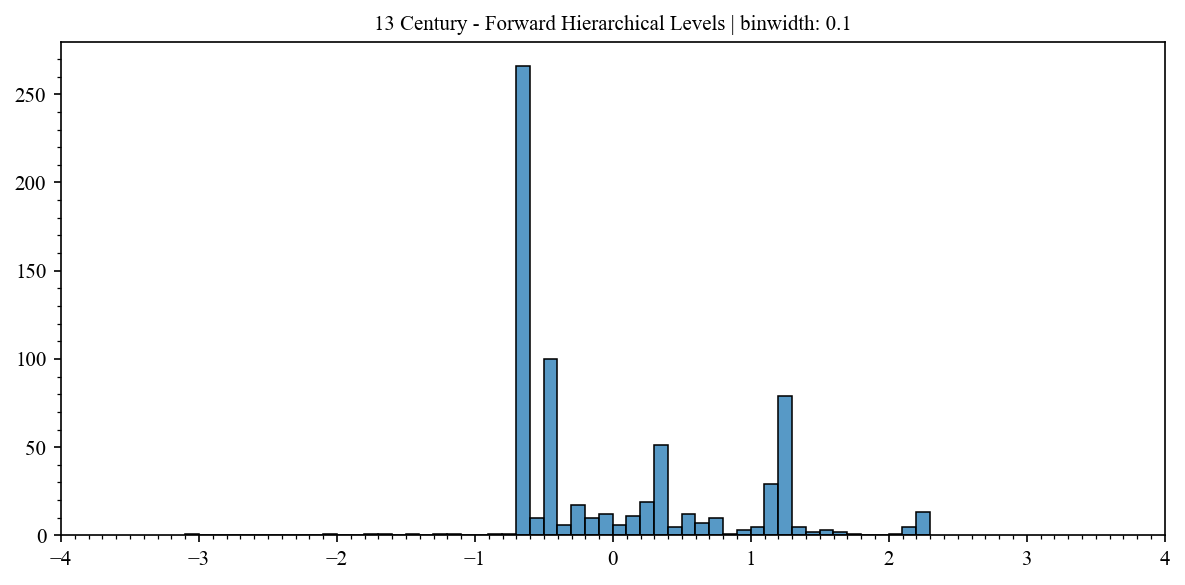

In [72]:
def plot_hirearchy_measure_single_cent(h_measures_df, cent, binwidth, figsize):
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 12

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    matplotlib.rcParams['font.serif'] = "Times New Roman"
    matplotlib.rcParams['font.family'] = "serif"
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

    plt.figure(figsize=figsize, dpi=150)

    h_levels_tmp = h_measures_df[h_measures_df['cent'] == cent]

    g = sns.histplot(
        data=h_levels_tmp, x='f_hierarchical_levels', binwidth=binwidth
    )
    
    g.set_title('{} Century - Forward Hierarchical Levels | binwidth: {}'.format(cent, binwidth), loc='center')
    g.set(xlabel='', ylabel='', xlim=(-4, 4))
    
    g.xaxis.set_major_locator(plt.MultipleLocator(1))
    g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    
    
    g.yaxis.set_major_locator(plt.MultipleLocator(50))
    g.yaxis.set_minor_locator(plt.MultipleLocator(10))

    plt.tight_layout()

    pass

plot_hirearchy_measure_single_cent(h_measures_df=h_measures_df, binwidth=0.1, cent='13', figsize=(8,4))

8it [00:01,  5.80it/s]


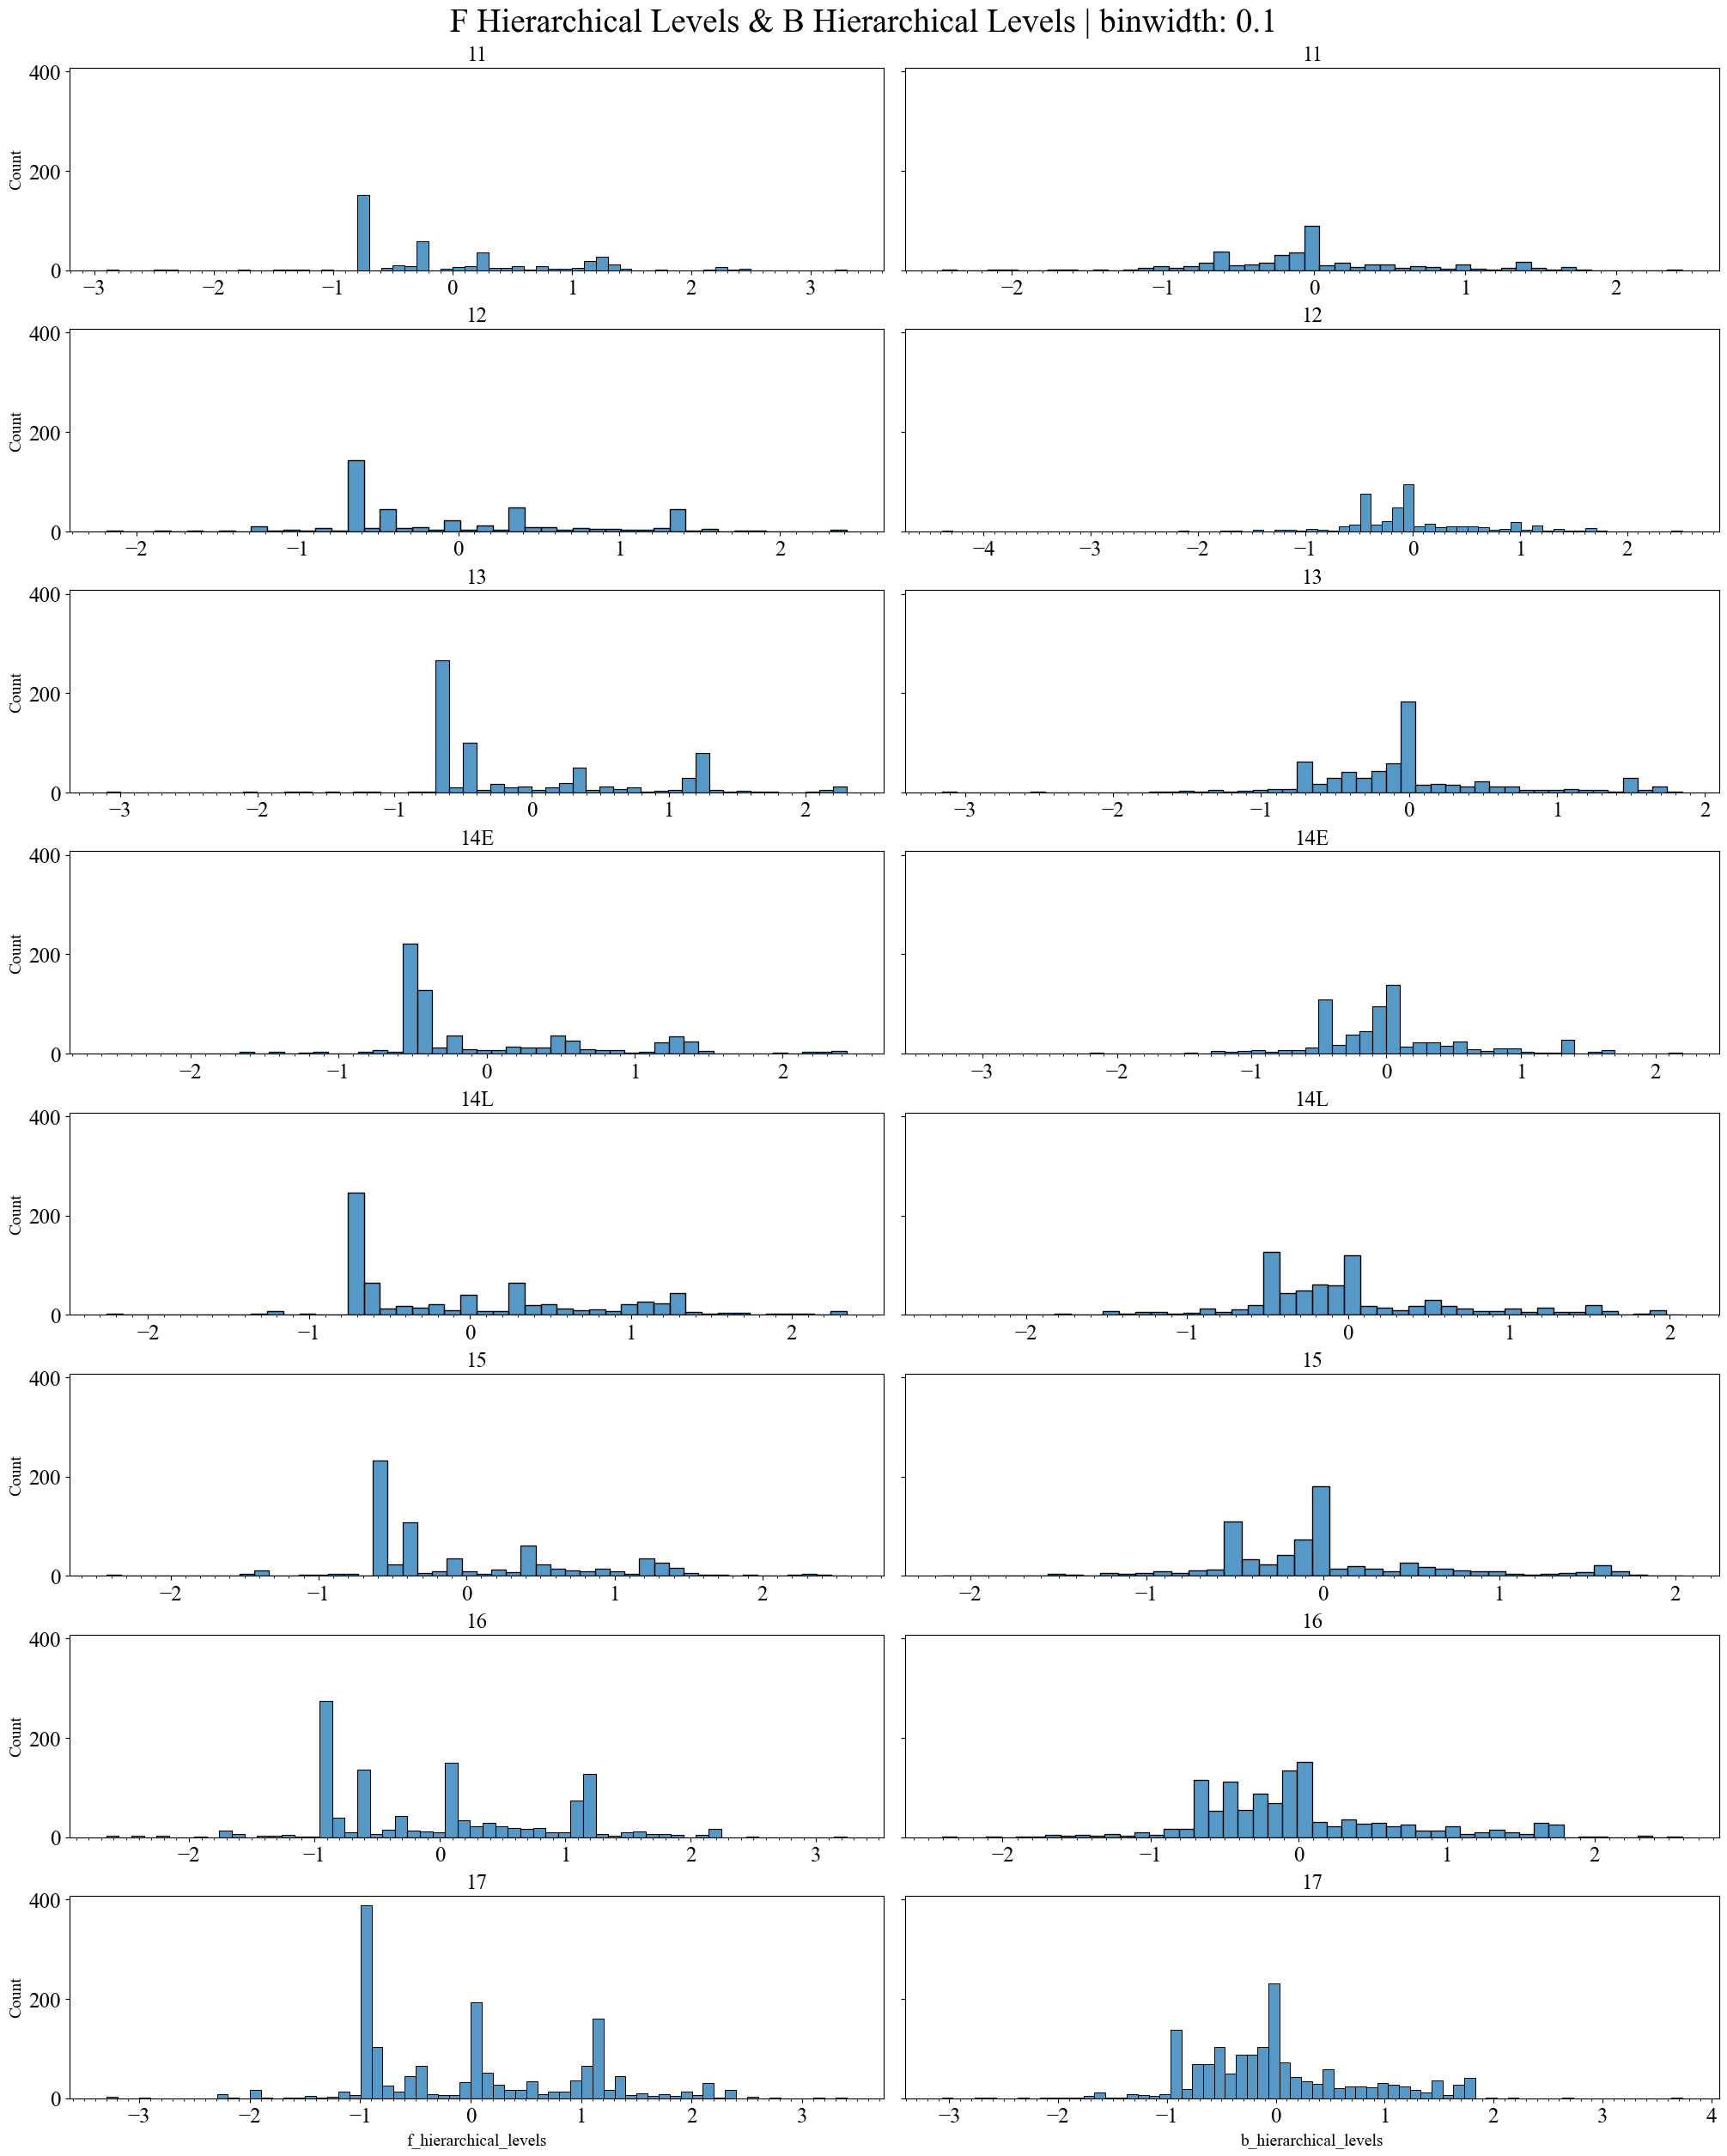

In [73]:
def plot_hirearchy_measure(h_measures_df, binwidth, func_names, ylim_dict=None):
    SMALL_SIZE = 18
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 28

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    matplotlib.rcParams['font.serif'] = "Times New Roman"
    matplotlib.rcParams['font.family'] = "serif"
    sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

    fig, axes = plt.subplots(nrows=len(cent_nets.keys()), ncols=2, constrained_layout=True,
        sharex=False, sharey=True, dpi=100, figsize=(20, 25))

    fig.suptitle('{} | binwidth: {}'.format(
        ' & '.join(func_names).replace('_', ' ').title(), binwidth
    ))
    
    cents = list(cent_nets.keys())
    
    for row, cent in tqdm(enumerate(cents)):

        h_levels_tmp = h_measures_df[h_measures_df['cent'] == cent]

        g = sns.histplot(
            data=h_levels_tmp, x=func_names[0],
            ax=axes[row, 0], binwidth=binwidth
        )
        
        g.set_title('{}'.format(cent), loc='center')
        
        g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
        
        # write xlabel only for last plot in column
        if cent != cents[-1]:
            g.set(xlabel='')
        
        if False:
            g.set(ylim=(0, ylim_dict[binwidth]) #, xlim=(0, 1), 
                  #xlabel=covars_latex_dicts[x_col], ylabel=covars_latex_dicts[y_col]
            )
            pass
#         g.xaxis.set_major_locator(plt.MultipleLocator(1))
#         g.yaxis.set_major_locator(plt.MultipleLocator(100))
#         print(ylim_dict[binwidth])
        '''-------------------------------'''
        g = sns.histplot(
            data=h_levels_tmp, x= func_names[1],
            ax=axes[row, 1], binwidth=binwidth
        )
        g.set_title('{}'.format(cent), loc='center')
        
        g.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
        
        # write xlabel only for last plot in column
        if cent != cents[-1]:
            g.set(xlabel='')
        
        if False:
            g.set(ylim=(0, ylim_dict[binwidth]) #, xlim=(0, 1), 
                  #xlabel=covars_latex_dicts[x_col], ylabel=covars_latex_dicts[y_col]
            )
            pass
#         g.xaxis.set_major_locator(plt.MultipleLocator(1))
#         g.yaxis.set_major_locator(plt.MultipleLocator(100))

        pass
    pass

binwidth = [0.1, None][0]
# func_name = ['hierarchical_levels', 'forward_hierarchical_levels'][1]
func_names = [
    ('hierarchical_levels', 'f_hierarchical_levels'),
    ('hierarchical_levels', 'b_hierarchical_levels'),
    ('f_hierarchical_levels', 'b_hierarchical_levels'),
    
#     ('f_influence_centrality', 'f_hierarchical_levels')
][-1]
# ylim_dicts={
#     ('forward_hierarchical_levels weighted', 'backward_hierarchical_levels weighted'): {
#         0.25:300, 0.5: 250, 0.75: 300, 1.0: 350, None: 400},
#     ('hierarchical_levels weighted', 'forward_hierarchical_levels weighted'): {None: 400},
#     ('hierarchical_levels weighted', 'backward_hierarchical_levels weighted'): {None: 400},
# }

plot_hirearchy_measure(h_measures_df=h_measures_df, 
                       binwidth=binwidth, 
#                        ylim_dict=ylim_dicts[func_names], 
                       func_names=func_names)

In [74]:
h_measures_df.describe()

,in_degree,out_degree,degree,hierarchical_levels,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence,diameter directed,cent_num
count,6479.000000,6479.000000,6479.000000,6.479000e+03,6.479000e+03,6.479000e+03,6.479000e+03,6.479000e+03,6.479000e+03,6.479000e+03,6479.000000,6479.000000,6479.000000,6479.000000
mean,1.964501,1.964501,3.929001,-3.838400e-17,-1.930167e-16,-1.206354e-16,1.095960e-02,4.350979e-01,3.224834e-07,9.335103e-05,0.529532,0.744574,11.503473,14.805803
std,6.313829,13.132097,14.945405,6.768780e-01,8.832146e-01,6.870449e-01,1.041155e-01,4.958082e-01,2.442888e-07,2.573640e-04,0.047072,0.147569,4.400098,1.823449
min,0.000000,0.000000,1.000000,-2.531639e+00,-3.297387e+00,-4.389230e+00,-2.846260e-04,-1.090786e-03,-1.678600e-07,-5.314202e-07,0.470407,0.569499,6.000000,11.000000
25%,1.000000,0.000000,1.000000,-4.185524e-01,-6.675310e-01,-4.412474e-01,-3.669949e-06,-4.191522e-07,1.500456e-07,-1.046224e-07,0.494748,0.676187,8.000000,14.100000
50%,1.000000,1.000000,2.000000,-8.934470e-02,-2.808688e-01,-4.426750e-02,2.405483e-07,2.111812e-05,4.567215e-07,5.426433e-08,0.514362,0.718737,10.000000,15.000000
75%,1.000000,2.000000,3.000000,4.827862e-01,6.168717e-01,2.423343e-01,6.257212e-06,1.000000e+00,5.397390e-07,8.837542e-08,0.535750,0.774719,16.000000,16.000000
max,261.000000,508.000000,508.000000,2.169174e+00,3.357849e+00,3.662322e+00,1.000000e+00,1.000002e+00,5.535885e-07,8.019334e-04,0.604553,1.232672,17.000000,17.000000


In [ ]:
# cen = '11'
# plt.figure(figsize=(15,8))
# sns.histplot(data=h_measures_df[h_measures_df['cent'] == cent], x='f_influence_centrality')

In [108]:
h_measures_df.columns

Index(['node', 'node func', 'in_degree', 'out_degree', 'degree',
       'hierarchical_levels', 'cent', 'f_hierarchical_levels',
       'b_hierarchical_levels', 'f_influence_centrality',
       'b_influence_centrality', 'f_democracy_coefficient',
       'b_democracy_coefficient', 'f_hierarchical_incoherence',
       'b_hierarchical_incoherence', 'diameter directed',
       'diameter undirected', 'cent_num'],
      dtype='object')

## FHL

In [77]:
h_measures_df['cent_FHL'] = h_measures_df.apply(lambda r: (r['cent'], round(r['f_hierarchical_levels'], 3)), axis=1)

In [78]:
nodes_FHL_df = (
    h_measures_df
    .groupby('node')
    .agg(
        FHL_avg=('f_hierarchical_levels', np.mean), 
        FHL_std=('f_hierarchical_levels', np.std), 
        count_cent=('cent', np.size),
        cent_FHL=('cent_FHL', lambda x: list(x))
    )
    .sort_values(by='FHL_std', ascending=False)
)

if False:
    nodes_FHL_df.to_excel('nodes_FHL_df.xlsx')
    
nodes_FHL_df[nodes_FHL_df.index == 'N geist']

,FHL_avg,FHL_std,count_cent,cent_FHL
node,,,,
N geist,0.140944,0.70163,8,"[(11, 1.277), (12, 0.191), (13, -0.676), (14E, 0.682), (14L, 0.318), (15, 0.253), (16, -0.921), (17, 0.003)]"


In [79]:
print('Number of nodes exists only single century (std=0):', sum(nodes_FHL_df['FHL_std'].isnull()), 'from', len(nodes_FHL_df))

for r in reversed(np.arange(0.5, 2.1, 0.25)):

    print('Number of Nodes with std >= {}: {} from {} | Exists in {} centuries'.format(
        r,
        sum(nodes_FHL_df['FHL_std'] >= r),
        sum(~nodes_FHL_df['FHL_std'].isnull()),
        round(nodes_FHL_df[nodes_FHL_df['FHL_std'] >= r]['count_cent'].mean(), 2)
    ))

Number of nodes exists only single century (std=0): 3314 from 4381
Number of Nodes with std >= 2.0: 4 from 1067 | Exists in 2.0 centuries
Number of Nodes with std >= 1.75: 12 from 1067 | Exists in 2.0 centuries
Number of Nodes with std >= 1.5: 23 from 1067 | Exists in 2.04 centuries
Number of Nodes with std >= 1.25: 67 from 1067 | Exists in 2.19 centuries
Number of Nodes with std >= 1.0: 130 from 1067 | Exists in 2.47 centuries
Number of Nodes with std >= 0.75: 205 from 1067 | Exists in 2.79 centuries
Number of Nodes with std >= 0.5: 337 from 1067 | Exists in 2.99 centuries


## Influence Centrality

In [80]:
'''Forward'''
heads_f_influence_centrality = h_measures_df[h_measures_df['f_influence_centrality'] > 0.1].groupby(['node', 'cent']).agg(count = ('cent', np.size))

head_f_influence = (
    heads_f_influence_centrality
    .reset_index()
    .pivot(index=['node'], columns='cent', values='count')
    .fillna(0)
)

head_f_influence['sum'] = head_f_influence.sum(axis=1)

head_f_influence = head_f_influence.sort_values(by=['sum'], ascending=False)

if False:
    head_f_influence.to_excel(path_dataset_dir + 'influence_cent_forward_high_0.1.xlsx')

head_f_influence

cent,11,12,13,14E,14L,15,16,17,sum
node,,,,,,,,,
AX sin,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AX werden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
V werden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
MV sollen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
MV wellen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
MV müssen,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,7.0
MV mögen,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
MV können,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,5.0
AX haben,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0


In [81]:
'''Backward'''
heads_f_influence_centrality = h_measures_df[h_measures_df['b_influence_centrality'] > 0.1].groupby(['node', 'cent']).agg(count = ('cent', np.size))

head_f_influence = (
    heads_f_influence_centrality
    .reset_index()
    .pivot(index=['node'], columns='cent', values='count')
    .fillna(0)
)

head_f_influence['sum'] = head_f_influence.sum(axis=1)

head_f_influence = head_f_influence.sort_values(by=['sum'], ascending=False)

if False:
    head_f_influence.to_excel(path_dataset_dir + 'influence_cent_backward_high_0.1.xlsx')

head_f_influence

cent,11,12,13,14E,14L,15,16,17,sum
node,,,,,,,,,
AJ unser,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AD so,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AR der,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
RP der,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
AJ all,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...
AJ vliegente,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
AJ viurec,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
AJ visibilis,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [115]:
[n for n in nodes_all_cent if 'werden' in n]

['AX werden', 'V werden', 'IV werden', 'PCPS werden']

[None, None]

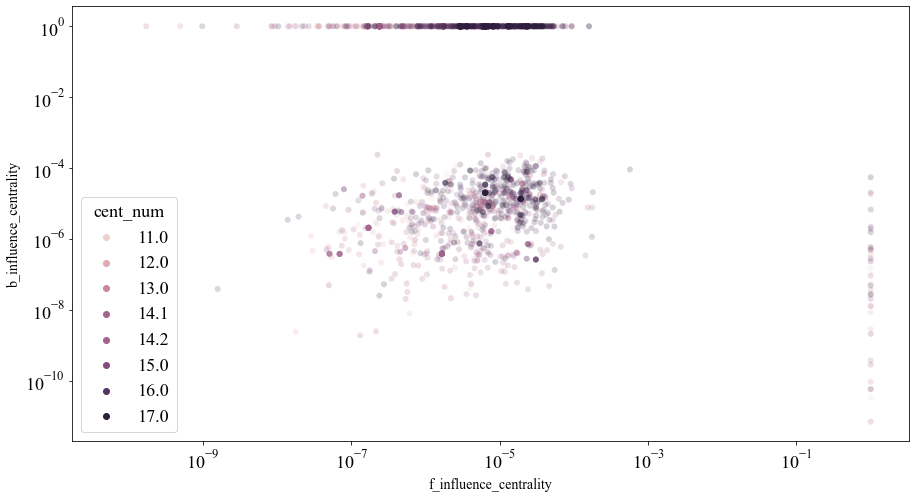

In [82]:
plt.figure(figsize=(15,8))

ax = sns.scatterplot(data=h_measures_df, x='f_influence_centrality', y='b_influence_centrality', 
                     hue='cent_num', alpha=0.2, linewidth=0, legend='full')

ax.set(xscale='log', yscale='log')

# h_measures_df['f_influence_centrality']

Text(0.5, 1.0, 'f_influence_centrality')

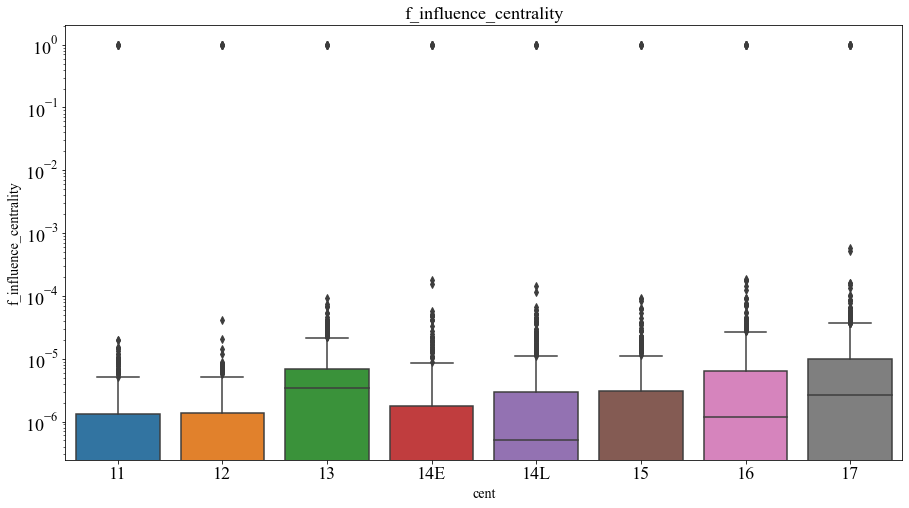

In [83]:
measure = ['f_influence_centrality'][0]

plt.figure(figsize=(15,8))
ax = sns.boxplot(data=h_measures_df, y=measure, x='cent')
ax.set(yscale="log")
ax.set_title(measure)

<AxesSubplot:xlabel='f_hierarchical_levels', ylabel='Count'>

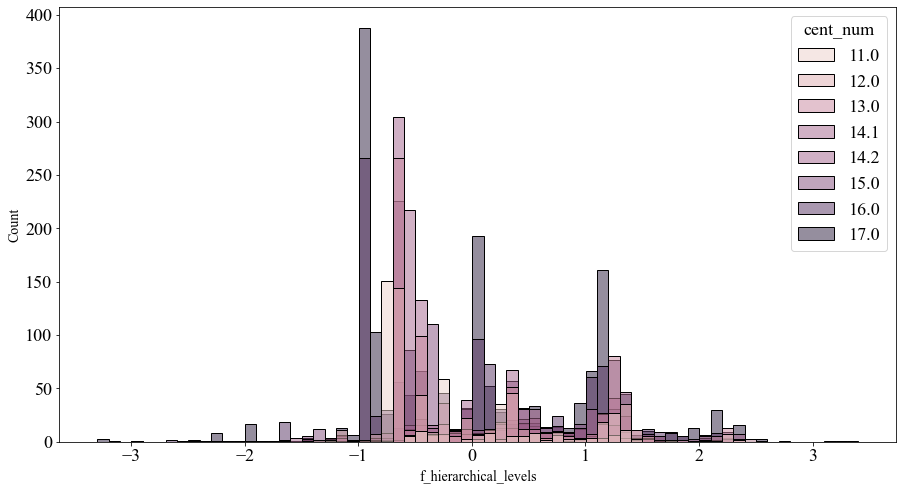

In [86]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='f_hierarchical_levels', hue='cent_num', binwidth=0.1)

<AxesSubplot:xlabel='b_hierarchical_levels', ylabel='Count'>

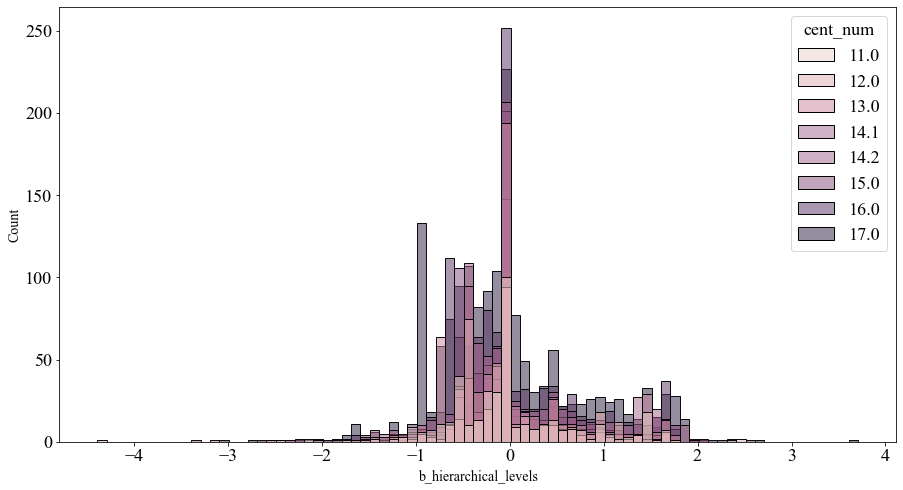

In [87]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='b_hierarchical_levels', hue='cent_num', binwidth=0.1)

<AxesSubplot:xlabel='hierarchical_levels', ylabel='Count'>

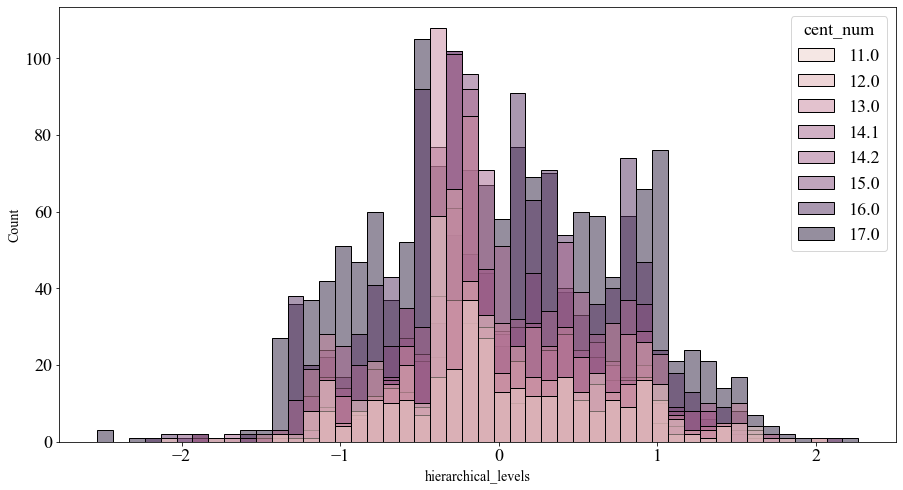

In [88]:
plt.figure(figsize=(15,8))
sns.histplot(data=h_measures_df, x='hierarchical_levels', hue='cent_num', binwidth=0.1)

In [123]:
# plt.figure(figsize=(15,8))
# sns.histplot(
#     data=h_levels_df[h_levels_df['cent'].isin(['11', '17'])], 
#     x='hierarchical_levels', hue='cent')

## Global Measures: Democracy Coeff and Hierarchical Incoherence

In [89]:
# %config Completer.use_jedi = False
# G.nodes
h_measures_df[h_measures_df['node'] == 'IV werden']

,node,node func,in_degree,out_degree,degree,hierarchical_levels,cent,f_hierarchical_levels,b_hierarchical_levels,f_influence_centrality,b_influence_centrality,f_democracy_coefficient,b_democracy_coefficient,f_hierarchical_incoherence,b_hierarchical_incoherence,diameter directed,diameter undirected,cent_num,cent_FHL
8,IV werden,IV,4,26,30,-1.317436,11,-1.260958,1.373913,2.470706e-09,-1.890120e-08,-1.678600e-07,4.644285e-11,0.534978,0.778689,7,None,11.0,"(11, -1.261)"
414,IV werden,IV,5,36,41,-1.251166,12,-1.018786,1.483546,-1.631267e-08,-9.613927e-09,-8.117385e-08,1.700172e-07,0.514362,1.232672,6,None,12.0,"(12, -1.019)"
859,IV werden,IV,5,43,48,-1.231289,13,-1.228381,1.234196,-1.836164e-08,6.373307e-08,4.567215e-07,7.475460e-08,0.485795,0.775513,10,None,13.0,"(13, -1.228)"
1552,IV werden,IV,6,75,81,-1.184048,14E,-1.258318,1.109778,-1.231735e-07,-2.506449e-08,7.203849e-08,5.426433e-08,0.494748,0.718737,6,None,14.1,"(14E, -1.258)"
2238,IV werden,IV,5,64,69,-1.193948,14L,-1.011108,1.376787,2.189525e-08,-7.649037e-10,1.500456e-07,8.019334e-04,0.500017,0.654909,8,None,14.2,"(14L, -1.011)"
2999,IV werden,IV,6,54,60,-1.143635,15,-1.034024,1.253245,-4.627078e-08,3.091720e-08,2.833530e-07,-1.046224e-07,0.470407,0.569499,9,None,15.0,"(15, -1.034)"
3733,IV werden,IV,8,71,79,-1.297171,16,-1.261204,1.333139,-4.308410e-07,3.828225e-09,5.535885e-07,8.837542e-08,0.535750,0.676187,17,None,16.0,"(16, -1.261)"
4921,IV werden,IV,11,100,111,-1.563474,17,-1.464881,1.662067,6.892789e-08,-9.300960e-08,5.397390e-07,-5.314202e-07,0.604553,0.774719,16,None,17.0,"(17, -1.465)"


In [90]:
G.edges[('AX werden', 'IV erben')]
gh.node_backward_influence_centrality(G, 'IV werden', weight='frequency')

-9.300960446267936e-08

In [91]:
dem_forw_df = []

for cent, G in tqdm(cent_nets.items()):
    FHD_adj, FHD_mean, FHD_std = gh.forward_hierarchical_incoherence(G, weight='frequency')
    
#     b_hierarchical_level_vector, b_influence_centrality_vector, b_hierarchical_diff_adj_sparse, b_democracy_coefficient, b_hierarchical_incoherence = gh.backward_hierarchical_metrics(G, weight='frequency')
    
    hierarchical_level_vector, influence_centrality_vector, hierarchical_diff_adj_sparse, democracy_coefficient, hierarchical_incoherence = gh.forward_hierarchical_metrics(G, weight='frequency')
    
    dem_forw_df.append(
        {
            'cent': cent,
            'forward_hierarchical_incoherence avg': FHD_mean,
            'forward_hierarchical_incoherence std': FHD_std,
            'forward_democracy_coefficient': gh.forward_democracy_coefficient(
                G, weight='frequency'),
            'backward_democracy_coefficient': gh.backward_democracy_coefficient(
                G, weight='frequency'),
            'democracy_coefficient': democracy_coefficient,
            'hierarchical_incoherence': hierarchical_incoherence
        }
    )
    
dem_forw_df = pd.DataFrame(dem_forw_df)
dem_forw_df['cent_num'] = dem_forw_df['cent'].map(centuries)
dem_forw_df

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.25it/s]


,cent,forward_hierarchical_incoherence avg,forward_hierarchical_incoherence std,forward_democracy_coefficient,backward_democracy_coefficient,democracy_coefficient,hierarchical_incoherence,cent_num
0,11,1.000000,0.534978,-1.678600e-07,4.644285e-11,-1.678600e-07,0.534978,11.0
1,12,1.000000,0.514362,-8.117385e-08,1.700172e-07,-8.117385e-08,0.514362,12.0
2,13,1.000000,0.485795,4.567215e-07,7.475460e-08,4.567215e-07,0.485795,13.0
3,14E,1.000000,0.494748,7.203849e-08,5.426433e-08,7.203849e-08,0.494748,14.1
4,14L,1.000000,0.500017,1.500456e-07,8.019334e-04,1.500456e-07,0.500017,14.2
5,15,1.000000,0.470407,2.833530e-07,-1.046224e-07,2.833530e-07,0.470407,15.0
6,16,0.999999,0.535750,5.535885e-07,8.837542e-08,5.535885e-07,0.535750,16.0
7,17,0.999999,0.604553,5.397390e-07,-5.314202e-07,5.397390e-07,0.604553,17.0


<AxesSubplot:xlabel='hierarchical_incoherence', ylabel='democracy_coefficient'>

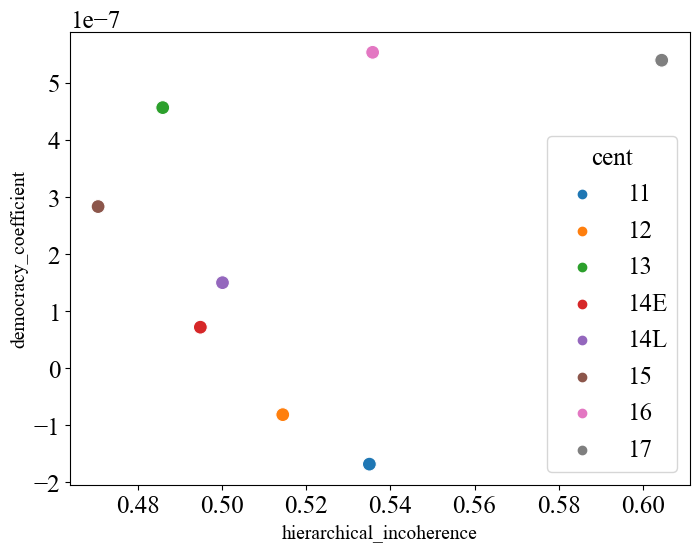

In [92]:
plt.figure(figsize=(8, 6), dpi=100)
sns.scatterplot(data=dem_forw_df, x="hierarchical_incoherence", y="democracy_coefficient", hue='cent',
               s=100, legend='full')

In [129]:
dem_forw_df

,cent,forward_hierarchical_incoherence avg,forward_hierarchical_incoherence std,forward_democracy_coefficient,backward_democracy_coefficient,democracy_coefficient,hierarchical_incoherence,cent_num
0,11,1.0,0.312015,1.111531e-07,2.631389e-09,1.111531e-07,0.312015,11.0
1,12,1.0,0.284485,-7.122441e-09,-3.869469e-08,-7.122441e-09,0.284485,12.0
2,13,1.0,0.321354,-1.390377e-07,-4.133028e-07,-1.390377e-07,0.321354,13.0
3,14E,1.0,0.335217,7.468562e-08,-2.734313e-07,7.468562e-08,0.335217,14.1
4,14L,1.0,0.300473,-5.237590e-08,8.035397e-04,-5.237590e-08,0.300473,14.2
5,15,1.0,0.296509,2.175005e-09,-3.498065e-07,2.175005e-09,0.296509,15.0
6,16,1.0,0.361358,2.795801e-08,-7.632451e-08,2.795801e-08,0.361358,16.0
7,17,1.0,0.410715,-1.377670e-07,1.189597e-07,-1.377670e-07,0.410715,17.0


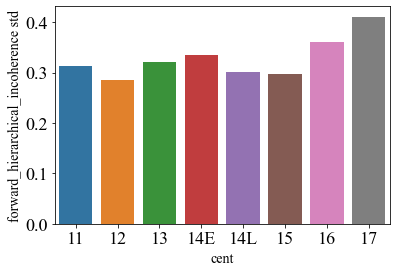

In [130]:
ax = sns.barplot(x="cent", y="forward_hierarchical_incoherence std", data=dem_forw_df)

In [ ]:
'UNWEIGHTED'

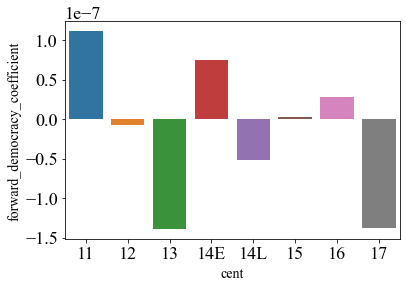

In [131]:
ax = sns.barplot(x="cent", y="forward_democracy_coefficient", data=dem_forw_df)

In [132]:
dem_forw_df

,cent,forward_hierarchical_incoherence avg,forward_hierarchical_incoherence std,forward_democracy_coefficient,backward_democracy_coefficient,democracy_coefficient,hierarchical_incoherence,cent_num
0,11,1.0,0.312015,1.111531e-07,2.631389e-09,1.111531e-07,0.312015,11.0
1,12,1.0,0.284485,-7.122441e-09,-3.869469e-08,-7.122441e-09,0.284485,12.0
2,13,1.0,0.321354,-1.390377e-07,-4.133028e-07,-1.390377e-07,0.321354,13.0
3,14E,1.0,0.335217,7.468562e-08,-2.734313e-07,7.468562e-08,0.335217,14.1
4,14L,1.0,0.300473,-5.237590e-08,8.035397e-04,-5.237590e-08,0.300473,14.2
5,15,1.0,0.296509,2.175005e-09,-3.498065e-07,2.175005e-09,0.296509,15.0
6,16,1.0,0.361358,2.795801e-08,-7.632451e-08,2.795801e-08,0.361358,16.0
7,17,1.0,0.410715,-1.377670e-07,1.189597e-07,-1.377670e-07,0.410715,17.0


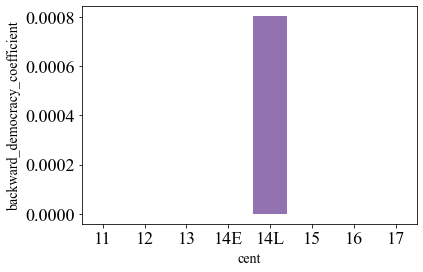

In [133]:
ax = sns.barplot(x="cent", y="backward_democracy_coefficient", data=dem_forw_df)

## Challenges

- https://stackoverflow.com/questions/57458789/get-bin-width-used-for-seaborn-plot
- ITS SO GOOD: https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
- https://stackoverflow.com/questions/56605113/how-to-set-x-axis-ticklabels-in-a-seaborn-plot

# [OLD] yFiles Hierarchical Layout

In [ ]:
path_yfiles_layout = 'D:/GoogleDrive/Research/Linguistic project/German/data/Hierarchical Layout yfiles/'

path_networks = OrderedDict()

path_networks['11'] = path_yfiles_layout + "/Cent11.cyjs" 
path_networks['12'] = path_yfiles_layout + "/Cent12.cyjs" 
path_networks['13'] = path_yfiles_layout + "/Cent13.cyjs" 
path_networks['14E'] = path_yfiles_layout + "/Cent14E.cyjs" 

path_networks['14L'] = path_yfiles_layout + "/Cent14L.cyjs" 
path_networks['15'] = path_yfiles_layout + "/Cent15.cyjs" 
path_networks['16'] = path_yfiles_layout + "/Cent16.cyjs" 
path_networks['17'] = path_yfiles_layout + "/Cent17.cyjs" 

In [ ]:
layouts = OrderedDict()
cen_layers = {}

for cent, path_layout in path_networks.items():
    f = open(path_layout, "r", encoding='utf-8')
    layouts[cent] = json.loads(f.read())
    
    cen_layers[cent] = []
    
    for node in layouts[cent]['elements']['nodes']:
        
        cen_layers[cent].append({
            'name': node['data']['name'],
            'x': node['position']['x'],
            'y': node['position']['y'],
            'y_round': round(node['position']['y'])
        })
        pass
    
    cen_layers[cent] = pd.DataFrame(cen_layers[cent])
    """Now convert unique y value to sequential layer number"""
    map_y_val_to_layer_num = {
        y: l + 1 for l, y in enumerate(sorted(set(cen_layers[cent]['y_round'])))
    }
    
    cen_layers[cent]['layer'] = cen_layers[cent]['y_round'].map(map_y_val_to_layer_num)
    
    cen_layers[cent] = cen_layers[cent].sort_values('layer').reset_index(drop=True)
#     break
    pass
# del layers
map_y_val_to_layer_num
cen_layers['17'].columns
# cen_layers.keys()

In [ ]:
cen_layer_count = []
for cen, cen_layer in cen_layers.items():
    cen_layer_count.append({
        'cent': cen,
        'num layers': cen_layer['layer'].max()
    })
    pass

cen_layer_count = pd.DataFrame(cen_layer_count)

cen_layers['cen_layer_count'] = cen_layer_count

cen_layers['cen_layer_count']

In [ ]:
%matplotlib inline

ax=sns.barplot(x="cent", y="num layers", data=cen_layer_count)
ax.set(ylim=(0, 30), title='Number of Layers in Each Century')

In [ ]:
save_xls(dfs_dict=cen_layers, 
         xls_path=path_yfiles_layout + '/all_cent_layers_yfiles.xlsx', 
         open=True)

# [OLD] Graph Hierarchy 
- How to draw netwrokx graph https://faculty.math.illinois.edu/~hirani/cbmg/graphs.html
- Add x-y axis when drawing with NetworkX https://stackoverflow.com/questions/56994061/how-to-make-x-and-y-axes-appear-when-using-networkx-and-matplotlib
- A cool toturial for visualization https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial

In [ ]:

graph = nx.gnr_graph(20, 0.4)
nx.draw_networkx(graph)

In [ ]:
l = list(zip(
    graph.nodes(),
#     gh.forward_hierarchical_levels(graph)
    gh.hierarchical_levels(graph)
))

l.sort(key=lambda x: x[1])
l

In [ ]:
level_dict = {}
level_num = 0
prev_layer_level = None
offset = 0

for node, level in l:
    if prev_layer_level is not None:
        offset = 1 - (level - prev_layer_level)
    
#     print('l: ', level, 'o: ', offset)
    
    if level not in level_dict:
        level_dict[level] = []
        level_num += 1
        prev_layer_level = level
        pass
    
    level_dict[level].append(node)
#     print(level + (np.sign(level) * 1))
    graph.nodes[node]['pos'] = (
        (len(level_dict[level]) * 2) + random.uniform(-1, 1),
        level 
    )
    pass

# plt.figure(3,figsize=(12,12)) 

fig, ax = plt.subplots()
fig.set_dpi(150)
fig.set_size_inches(10,10)
pos=nx.get_node_attributes(graph,'pos')

plt.figure(3,figsize=(12,12)) 

nx.draw_networkx(graph, pos, ax=ax)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

In [ ]:
print('levels: ', len(level_dict))

In [ ]:
node_l_dict = dict(l)
node_l_dict[0] - node_l_dict[1]

In [ ]:
gh.forward_hierarchical_differences(graph)


In [ ]:
(hierarchical_differences_sparse, 
 hierarchical_differences_mean, 
 hierarchical_differences_std) = gh.forward_hierarchical_incoherence(graph)

"""The standard deviation of the distribution is known as the forward hierarchical incoherence and is an important metric which gives a measure of a network's organisation and structure."""
print('mean:', hierarchical_differences_mean, 'std:' , hierarchical_differences_std)

In [ ]:
gh.forward_democracy_coefficient(graph)

In [ ]:
for node in graph.nodes:
    print(node, gh.node_forward_influence_centrality(graph, node))

In [ ]:
gh.forward_influence_centrality(graph)


In [ ]:
gh.hierarchical_levels(graph)
